In [1]:
# Setup and Imports
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython.display import Image, display

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Ensure project_root is defined for subsequent cells
print(f'Project Root: {project_root}')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Common imports
from src.envs.synthetic_env import BouncingBallEnv
from src.envs.atari_env import AtariPixelEnv
from src.models.vae import VAE
from src.models.transition import TransitionModel
from src.models.agent import ActiveInferenceAgent
from src.trainer import ActiveInferenceTrainer

Project Root: /Users/yezune/ws/from_pixels_to_planning
Using device: cpu


objc[38397]: Class CaptureDelegate is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x1180f25d8) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_videoio.4.12.0.dylib (0x12c9a4618). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[38397]: Class CVWindow is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x1180f2628) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x12c368a70). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[38397]: Class CVView is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x1180f2650) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x12c368a98). This may cause spu

# Experiment 3: Bouncing Ball

## 1. Bouncing Ball Experiment (Phase 4)

We train a Flat Active Inference Agent on the Bouncing Ball environment and visualize the VAE reconstruction.

Training VAE...


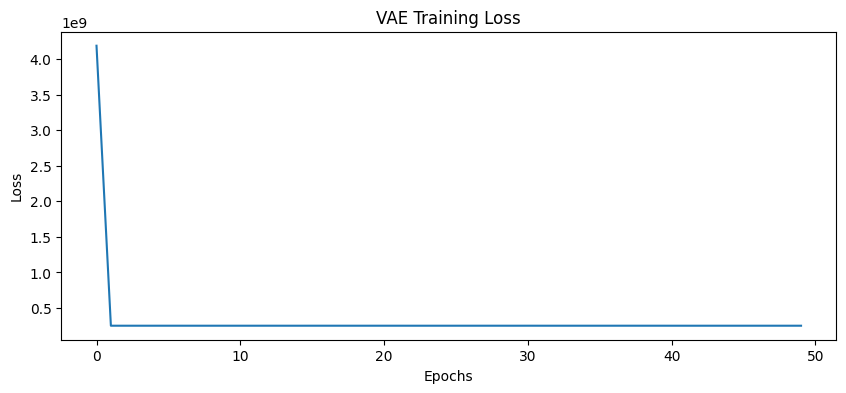

In [2]:
# Initialize Environment and Agent
env = BouncingBallEnv(size=32)
obs_shape = (3, 32, 32)
action_dim = env.action_space.n

vae = VAE(input_shape=obs_shape, latent_dim=16).to(device)
trans = TransitionModel(latent_dim=16, action_dim=action_dim, hidden_dim=32).to(device)
agent = ActiveInferenceAgent(vae, trans, action_dim, device=device)

trainer = ActiveInferenceTrainer(
    env=env,
    agent=agent,
    buffer_size=1000,
    batch_size=16,
    lr=1e-3,
    device=device
)

# Collect Data and Train (Short Run)
print("Collecting data...")
trainer.collect_data(num_steps=200)

print("Training VAE...")
vae_losses = []
for _ in range(50):
    loss = trainer.train_vae(epochs=1)
    vae_losses.append(loss)

plt.figure(figsize=(10, 4))
plt.plot(vae_losses)
plt.title("VAE Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

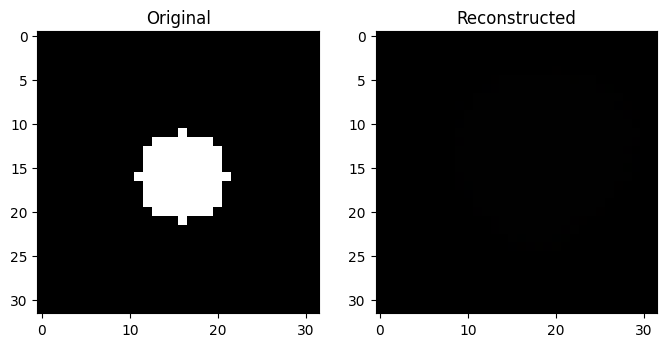

In [3]:
# Visualize Reconstruction
def visualize_reconstruction(agent, env):
    obs, _ = env.reset()
    
    # Prepare input
    if not isinstance(obs, torch.Tensor):
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
    else:
        obs_tensor = obs.to(device)
        
    # Permute if needed (H, W, C) -> (C, H, W)
    if obs_tensor.shape[-1] == 3:
        obs_tensor = obs_tensor.permute(2, 0, 1)
    
    obs_tensor = obs_tensor.unsqueeze(0) # Add batch dim
    
    with torch.no_grad():
        recon, _, _ = agent.vae(obs_tensor)
        
    # Convert back to numpy for plotting
    orig_img = obs_tensor.squeeze().permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    recon_img = recon.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_img = np.clip(recon_img, 0, 255).astype(np.uint8)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(orig_img)
    axes[0].set_title("Original")
    axes[1].imshow(recon_img)
    axes[1].set_title("Reconstructed")
    plt.show()

visualize_reconstruction(agent, env)